In [1]:
import io
import sys
import os
import time
import picamera
import numpy as np
from time import sleep
import time
import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
from tqdm import tqdm_notebook as tqdm
from astropy.io import fits
from instrumental import instrument, list_instruments, u

In [2]:
path = "/media/pi/TOLIMAN-1/data"
os.chdir(path)

In [3]:
devices = list_instruments()
[device for  device in devices]
instruments = [instrument(device) for device in devices]
z = instruments[0]
y = instruments[1]
x = instruments[2]

In [4]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [5]:
def move(axis, dist, cen):
    pos = cen + dist/1000
    with HiddenPrints():
        axis.move_to(pos*u.mm)

In [6]:
def get_rgb_new(stream):
    
    offset = 10270208
    data = stream.getvalue()[-offset:]
    data = data[32768:]
    data = np.frombuffer(data, dtype=np.uint8)

    reshape_val = (2480, 4128)
    crop = (2464, 4100)
    data = data.reshape(reshape_val)[:crop[0], :crop[1]]

    data = data.astype(np.uint16) << 2
    for byte in range(4):
        data[:, byte::5] |= ((data[:, 4::5] >> ((4 - byte) * 2)) & 0b11)
    data_array = np.delete(data, np.s_[4::5], 1)
    
    # RGGB
    array_out = np.array([data_array[1::2, 1::2], data_array[1::2, 0::2], data_array[0::2, 1::2], data_array[0::2, 0::2]])    
    return array_out

In [7]:
def take_im(c, file_string, header):
    stream = io.BytesIO()
    c.capture(stream, format='jpeg', bayer=True)
    rgb = get_rgb_new(stream)
#     fits.PrimaryHDU(rgb).writeto(file_string, rgb, header=header)
    fits.writeto(file_string, rgb, header=header)
    stream.flush()
    stream.close()
    del stream

In [8]:
def get_im(c):
    stream = io.BytesIO()
    c.capture(stream, format='jpeg', bayer=True)
    rgb = get_rgb_new(stream)
    stream.flush()
    stream.close()
    del stream
    return rgb

In [9]:
xmin = 0
xmax = xmin + 5.2
cx = (xmax-xmin)/2

ymin = 2.235
ymax = ymin + 3.90
cy = (ymax+ymin)/2

move(x, 0, cx)
move(y, 0, cy)

In [10]:
move(x, 150, cx)
move(y, 0, cy)

In [11]:
x_res = 3280//2
y_res = 2464//2
sub_dir = "test"

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
    c.shutter_speed = 20000

    # Get file names
    file_names = os.listdir(path + "/{}".format(sub_dir))
    
    # Get first available string name
    im_num = 0
    test_string = "test_{}.fits".format(im_num)
    while test_string in file_names:
        im_num += 1
        test_string = "test_{}.fits".format(im_num)
    file_name = path + "/{}/".format(sub_dir) + test_string  
    
    # Generate header data
    T = time.localtime() # Get date and time
    header = fits.Header()
    header["NAXIS"] = 3
    header["NAXIS1"] = x_res
    header["NAXIS2"] = y_res
    header["NAXIS3"] = 4 # RGGB
    header["DATE"] = "{}-{}-{}".format(T.tm_mday, T.tm_mon, T.tm_year)
    header["TIME"] = "{}:{}:{}".format(T.tm_hour, T.tm_min, T.tm_sec)
    header["SSPEED"] = c.shutter_speed
    header["FRATE"] = c.framerate.numerator/c.framerate._denominator
    
    # Take image
    take_im(c, file_name, header)
    
im = fits.open(file_name)[0].data

In [12]:
header = fits.getheader(file_name)
for key in header.keys():
        print(key, header[key])

SIMPLE True
BITPIX 16
NAXIS 3
NAXIS1 1640
NAXIS2 1232
NAXIS3 4
DATE 17-11-2019
TIME 16:46:30
SSPEED 19991
FRATE 10.0
BSCALE 1
BZERO 32768


In [13]:
c1 = im.shape[1]//2 # x centre
c2 = im.shape[2]//2 # y centre
s1 = 200 # Central size
s2 = 300 # Corner size
off = (x_res-y_res)//2 #offset
order = ["Red", "Green 1", "Green 2", "Blue"]

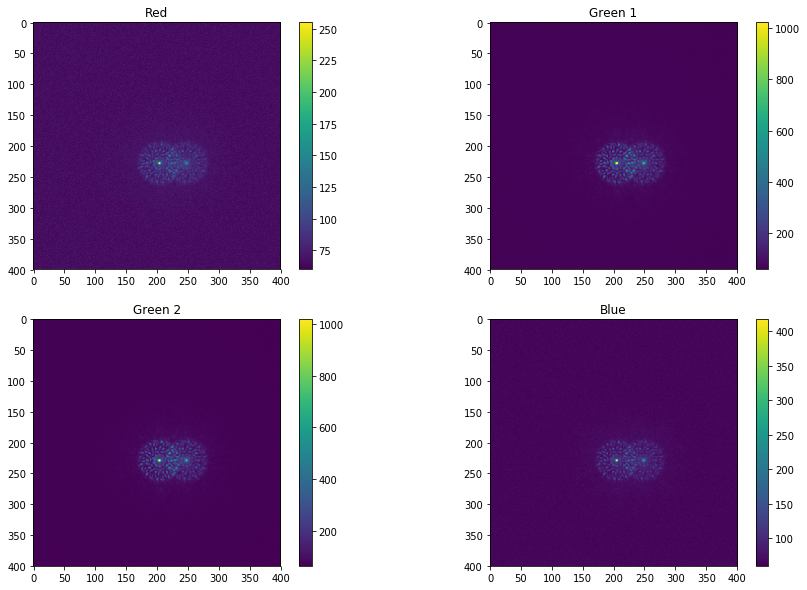

In [14]:
fig = plt.figure(figsize=(15,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("{}".format(order[i]))
    plt.imshow(im[i][c1-s1:c1+s1, c2-s1:c2+s1])
    plt.colorbar()
    
plt.show()

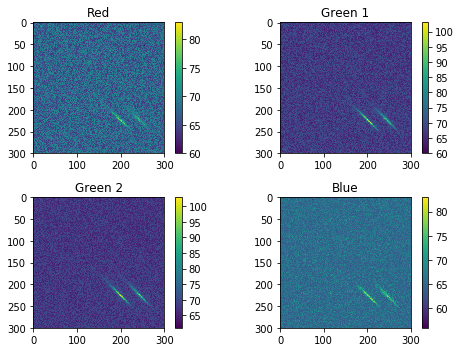

In [15]:
fig = plt.figure(figsize=(7,5))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("{}".format(order[i]))
    plt.imshow(im[i][0:s2, off:s2+off])
    plt.colorbar()
    
plt.tight_layout()
plt.show()

---
# ADD LIGHT SOURCE HERE

In [19]:
light_source = "530_530"

## Take nulls

In [16]:
x_res = 3280//2
y_res = 2464//2
sub_dir = "no_temp/{}/nulls".format(light_source)

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
    c.shutter_speed = 20000

    for idx in tqdm(range(100)):
        test_string = "null_{}.fits".format(idx)
        file_name = path + "/{}/".format(sub_dir) + test_string  

        # Generate header data
        T = time.localtime() # Get date and time
        header = fits.Header()
        header["NAXIS"] = 3
        header["NAXIS1"] = x_res
        header["NAXIS2"] = y_res
        header["NAXIS3"] = 4 # RGGB
        header["DATE"] = "{}-{}-{}".format(T.tm_mday, T.tm_mon, T.tm_year)
        header["TIME"] = "{}:{}:{}".format(T.tm_hour, T.tm_min, T.tm_sec)
        header["SSPEED"] = c.shutter_speed
        header["FRATE"] = c.framerate.numerator/c.framerate._denominator

        # Take image
        take_im(c, file_name, header)

In [18]:
phis = np.linspace(0, 2*np.pi, endpoint=False, num=32)
rs = np.linspace(50, 250, num=201)
print(rs)
print(phis/(np.pi))

[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 244. 245.
 246. 

In [20]:
shutter_speeds = np.linspace(10000, 30000, 11)
print(shutter_speeds)

[10000. 12000. 14000. 16000. 18000. 20000. 22000. 24000. 26000. 28000.
 30000.]


In [21]:
num_frames = 25

In [22]:
x_res = 3280//2
y_res = 2464//2
sub_dir = "no_temp/{}/data".format(light_source)

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
    c.shutter_speed = 20000
    
    
    idx = 0
    
    while True:
        for shutter_speed in shutter_speeds:
            move(x, 0, cx)
            move(y, 0, cy)
            sleep(5)

            for r in rs:
                for phi in phis:
                    X = r*np.cos(phi)
                    Y = r*np.sin(phi)

                    # Move to new position and give time to get there
                    move(x, X, cx)
                    move(y, Y, cy)
                    sleep(2)

                    for i in tqdm(range(num_frames), leave=False):
                        test_string = "image_{}.fits".format(idx)
                        file_name = path + "/{}/".format(sub_dir) + test_string  

                        # Generate header data
                        T = time.localtime() # Get date and time
                        header = fits.Header()
                        header["NAXIS"] = 3
                        header["NAXIS1"] = x_res
                        header["NAXIS2"] = y_res
                        header["NAXIS3"] = 4 # RGGB
                        header["DATE"] = "{}-{}-{}".format(T.tm_mday, T.tm_mon, T.tm_year)
                        header["TIME"] = "{}:{}:{}".format(T.tm_hour, T.tm_min, T.tm_sec)
                        header["SSPEED"] = c.shutter_speed
                        header["FRATE"] = c.framerate.numerator/c.framerate._denominator
                        header["R"] = r
                        header["PHI"] = phi
                        header["XPOS"] = X
                        header["YPOS"] = Y
                        header["IDX"] = idx
                        header["IM_NUM"]  = i

                        # Take image
                        take_im(c, file_name, header)
                        
                        idx += 1

OSError: File '/media/pi/TOLIMAN-1/data/no_temp/530_530/data/image_0.fits' already exists.

In [ ]:
output_strings = []

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
    c.shutter_speed = 1000000

    # Take inital centered image
    file_string = path + "/{}/centered_{}.fits".format(sub_dir, c.shutter_speed)
    output_strings.append(file_string)
    take_im(c, file_string)
    
    # Position counter
    i1 = 1
    for r in tqdm(rs):
        for phi in tqdm(phis, leave = False):
            
            # Convert r, phi values to x, y positions
            X = r*np.cos(phi)
            Y = r*np.sin(phi)
            
            # Move to new position and give time to get there
            move(x, X, cx)
            move(y, Y, cy)
            sleep(2)
            
            # Image counter
            for i2 in tqdm(range(5), leave=False):
                file_string = path + "/{}/{}-{}_{}_{}_{}.fits".format(sub_dir, i1, i2, r/100, phi/(np.pi), c.shutter_speed)
                output_strings.append(file_string)
                take_im(c, file_string)

            i1 += 1
            
    # Take final centered image
    file_string = path + "/{}/re_centered_{}.fits".format(sub_dir, c.shutter_speed)
    output_strings.append(file_string)
    take_im(c, file_string)

print("done")

In [159]:
num_images = len(output_strings)
print(num_images)

202


In [160]:
im_string = output_strings[11 + 40 + 40 + 40 + 40]
im = fits.open(im_string)[0].data
print(im_string)

/media/pi/TOLIMAN-1/data/halogen/35-0_3.0_0.5_85.fits


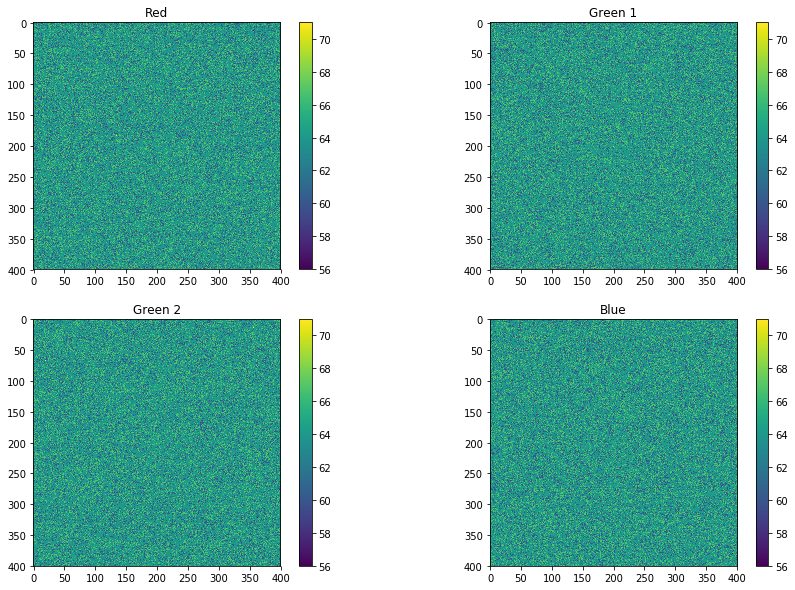

In [161]:
fig = plt.figure(figsize=(15,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("{}".format(order[i]))
    plt.imshow(im[i][c1-s1:c1+s1, c2-s1:c2+s1])
    plt.colorbar()
plt.show()    